# Проект: Линейные модели в машинном обучении

К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия контракта позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

* Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
* Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:

* Средний удой за год — не менее 6000 килограммов.

* Молоко должно быть вкусным.

## Шаг 1. Загрузка данных

Загрузим и проанализируем предоставленные данные.

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import spearmanr
from scipy.stats import binom, norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import phik
from phik import resources
from phik.report import plot_correlation_matrix
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score
)

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
ferma_main.columns = ferma_main.columns.str.replace('_', ' ')
ferma_main.head(10)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинные,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


Мы видим, что названия столбцов некорректны. Оставим русские названия для большей наглядности и понятности. Все названия будут начинаться с большой буквы и вместо нижнего подчеркивания используем пробел.

In [4]:
ferma_main.columns = ferma_main.columns.str.replace('порода папы быка', 'Порода папы быка')
print(*ferma_main.columns, sep="\n")

id
Удой, кг
ЭКЕ (Энергетическая кормовая единица)
Сырой протеин, г
СПО (Сахаро-протеиновое соотношение)
Порода
Тип пастбища
Порода папы быка
Жирность,%
Белок,%
Вкус молока
Возраст


In [5]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
ferma_dad.columns = ferma_dad.columns.str.replace('_', ' ')
ferma_dad.head(10)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


In [6]:
ferma_dad.columns = ferma_dad.columns.str.replace('Имя Папы', 'Имя папы')
print(*ferma_dad.columns, sep="\n")

id
Имя папы


In [7]:
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
cow_buy.columns = cow_buy.columns.str.replace('_', ' ')
cow_buy.columns = cow_buy.columns.str.replace('Текущая жирность,%', 'Жирность,%')
cow_buy.columns = cow_buy.columns.str.replace('Текущий уровень белок,%', 'Белок,%')
cow_buy.head(10)

,Порода,Тип пастбища,порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


In [8]:
cow_buy.columns = cow_buy.columns.str.replace('порода папы быка', 'Порода папы быка')
print(*cow_buy.columns, sep="\n")

Порода
Тип пастбища
Порода папы быка
Имя папы
Жирность,%
Белок,%
Возраст


## Шаг 2.  Предобработка данных

In [9]:
#Проверим, есть ли пропуски в таблице фермы.
ferma_main.isna().sum()

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
Порода папы быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

Пропусков нет.

In [10]:
#Проверим, есть ли пропуски в таблице с именами отцов коров.
ferma_dad.isna().sum()

id          0
Имя папы    0
dtype: int64

Пропусков нет.

In [11]:
#Проверим, есть ли провпуски в таблице "ЭкоФермы".
cow_buy.isna().sum()

Порода              0
Тип пастбища        0
Порода папы быка    0
Имя папы            0
Жирность,%          0
Белок,%             0
Возраст             0
dtype: int64

Пропусков нет.

In [12]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   Порода папы быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [13]:
ferma_main.duplicated().sum()

5

Есть дубликаты. Удалим их.

In [14]:
ferma_main[ferma_main.duplicated()]

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [15]:
ferma_main.drop_duplicates(inplace=True)
ferma_main.duplicated().sum()

0

In [16]:
print(*ferma_main['Тип пастбища'].unique(), sep="\n")

Равнинное
Равнинные
Холмистое


In [17]:
ferma_main['Тип пастбища'] = ferma_main['Тип пастбища'].replace('Равнинные','Равнинное')
print(*ferma_main['Тип пастбища'].unique(), sep="\n")

Равнинное
Холмистое


In [18]:
print(*ferma_main['Порода папы быка'].unique(), sep="\n")

Айдиал
Соверин
Айдиалл


In [19]:
ferma_main['Порода папы быка'] = ferma_main['Порода папы быка'].replace('Айдиалл','Айдиал')
print(*ferma_main['Порода папы быка'].unique(), sep="\n")

Айдиал
Соверин


In [20]:
ferma_main['Возраст'] = ferma_main['Возраст'].replace('более_2_лет','Более 2 лет')
ferma_main['Возраст'] = ferma_main['Возраст'].replace('менее_2_лет','Менее 2 лет')
print(*ferma_main['Возраст'].unique(), sep="\n")

Более 2 лет
Менее 2 лет


In [21]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [22]:
ferma_dad.duplicated().sum()

0

In [23]:
print(*ferma_dad['Имя папы'].unique(), sep="\n")

Буйный
Соловчик
Барин
Геркулес


In [24]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Порода            20 non-null     object 
 1   Тип пастбища      20 non-null     object 
 2   Порода папы быка  20 non-null     object 
 3   Имя папы          20 non-null     object 
 4   Жирность,%        20 non-null     float64
 5   Белок,%           20 non-null     float64
 6   Возраст           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [25]:
cow_buy.duplicated().sum()

4

In [26]:
cow_buy[cow_buy.duplicated()]

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Видим, что в ассоциации пастбищ "ЭкоФерма" есть коровы с одинаковыми характеристиками. Я считаю, что их стоит оставить.

In [27]:
cow_buy['Тип пастбища'] = cow_buy['Тип пастбища'].replace('равнинное','Равнинное')
cow_buy['Тип пастбища'] = cow_buy['Тип пастбища'].replace('холмистое','Холмистое')
print(*cow_buy['Тип пастбища'].unique(), sep="\n")

Холмистое
Равнинное


In [28]:
print(*cow_buy['Порода папы быка'].unique(), sep="\n")

Айдиал
Соверин


In [29]:
print(*cow_buy['Имя папы'].unique(), sep="\n")

Геркулес
Буйный
Барин
Соловчик


In [30]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Порода            20 non-null     object 
 1   Тип пастбища      20 non-null     object 
 2   Порода папы быка  20 non-null     object 
 3   Имя папы          20 non-null     object 
 4   Жирность,%        20 non-null     float64
 5   Белок,%           20 non-null     float64
 6   Возраст           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Вывод: скорректировали названия в полученных данных, удалили дубликаты, проверили отсутствие пропусков и убедились в корректности типов данных.

## Шаг 3. Исследовательский анализ данных

Проведем статистический анализ признаков и создадим соответствующие графики.

In [31]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,Более 2 лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,Менее 2 лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,Более 2 лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,Более 2 лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,Менее 2 лет


In [32]:
#Cтатистика удоя.
ferma_main['Удой, кг'].describe()

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: Удой, кг, dtype: float64

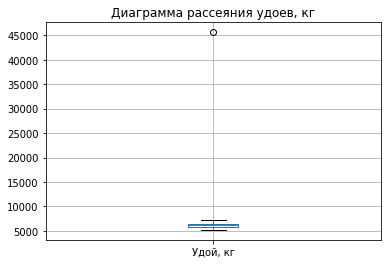

In [33]:
#График "box plot" для удоя.
ferma_main.boxplot(column='Удой, кг')
plt.title('Диаграмма рассеяния удоев, кг')
plt.show()

In [34]:
#В данных есть одно аномальное значение. Удалим его.
ferma_main = ferma_main.loc[ferma_main['Удой, кг'] < 45000]

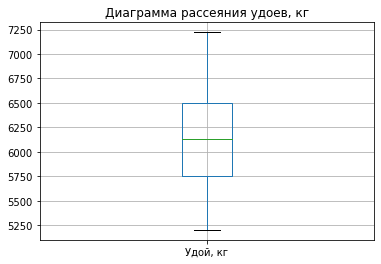

In [35]:
#График "box plot" для удоя без аномального значения.
ferma_main.boxplot(column='Удой, кг')
plt.title('Диаграмма рассеяния удоев, кг')
plt.show()

In [36]:
ferma_main['Удой, кг'].describe()

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: Удой, кг, dtype: float64

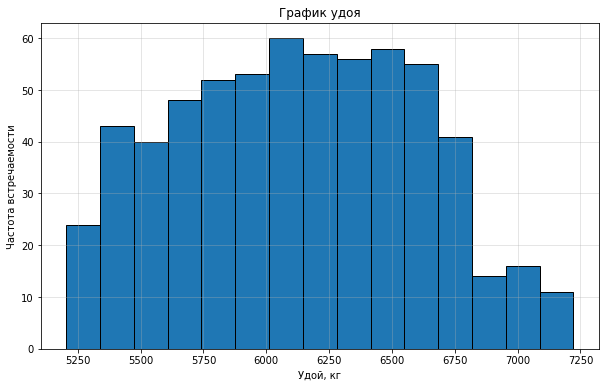

In [37]:
data = ferma_main['Удой, кг']

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, edgecolor='black')
plt.xlabel("Удой, кг")
plt.ylabel("Частота встречаемости")
plt.title("График удоя")
plt.grid(axis='both', alpha=.4)
plt.show()

На гистограмме видно, что основной удой находится в диапазоне от 5750 до 6500 килограммов в год. Данные не имеют нормального расспределения.

In [38]:
#Посмотрим на статистику ЭКЕ(Энергетическая кормовая единица).
ferma_main['ЭКЕ (Энергетическая кормовая единица)'].describe()

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: ЭКЕ (Энергетическая кормовая единица), dtype: float64

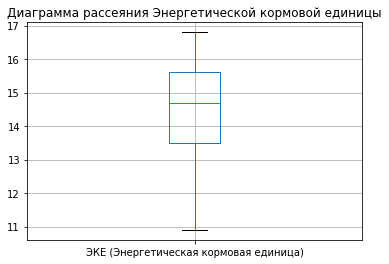

In [39]:
#График "box plot" для ЭКЕ.
ferma_main.boxplot(column='ЭКЕ (Энергетическая кормовая единица)')
plt.title('Диаграмма рассеяния Энергетической кормовой единицы')
plt.show()

Аномальных значений нет.

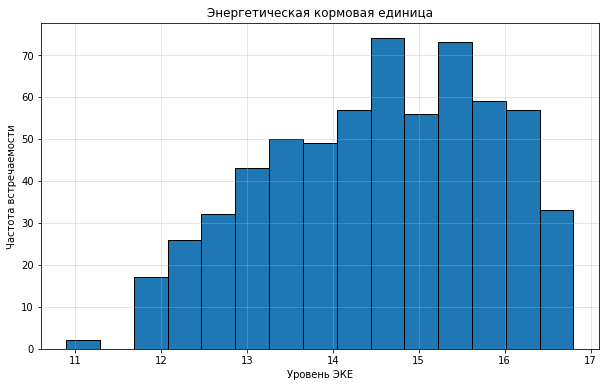

In [40]:
data = ferma_main['ЭКЕ (Энергетическая кормовая единица)']

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, edgecolor='black')
plt.title("Энергетическая кормовая единица")
plt.xlabel("Уровень ЭКЕ")
plt.ylabel("Частота встречаемости")
plt.grid(axis='both', alpha=.4)
plt.show()

Видим, что показатель "ЭКЕ" преимущественно находится в диапазоне от 13.5 до 15.6. 

In [41]:
#Посмотрим на статистику Сырой протеин, г.
ferma_main['Сырой протеин, г'].describe()

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: Сырой протеин, г, dtype: float64

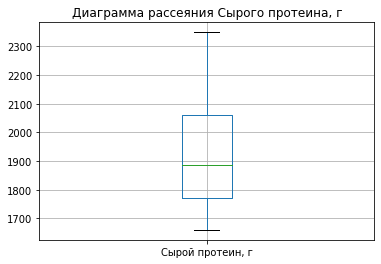

In [42]:
#График "box plot" для Сырой протеин, г.
ferma_main.boxplot(column='Сырой протеин, г')
plt.title('Диаграмма рассеяния Сырого протеина, г')
plt.show()

Аномальных значений нет.

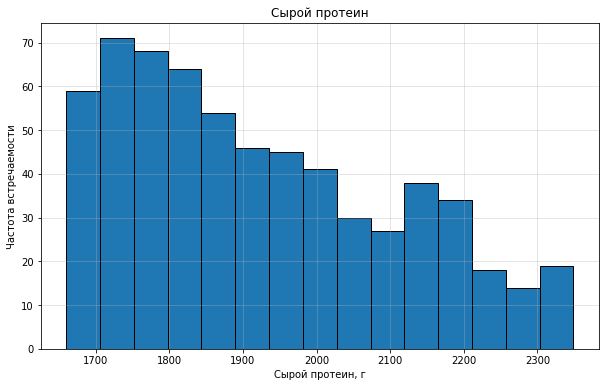

In [43]:
data = ferma_main['Сырой протеин, г']

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, edgecolor='black')
plt.title("Сырой протеин")
plt.xlabel("Сырой протеин, г")
plt.ylabel("Частота встречаемости")
plt.grid(axis='both', alpha=.4)
plt.show()

Можно заметить, что показатель "Сырой протеин, г" преимущественно находится в диапазоне от 1772 до 2062.

In [44]:
#Теперь посмотрим на статистику СПО (Сахаро-протеиновое соотношение).
ferma_main['СПО (Сахаро-протеиновое соотношение)'].describe()

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: СПО (Сахаро-протеиновое соотношение), dtype: float64

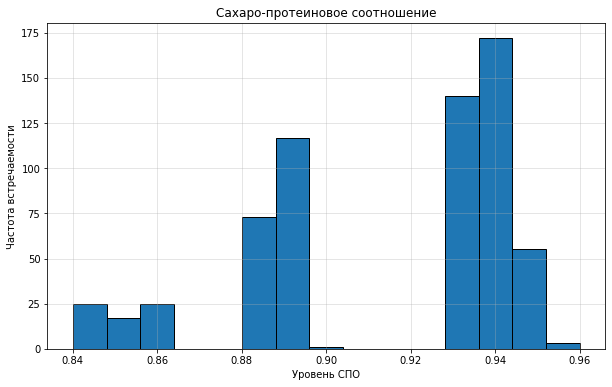

In [45]:
data = ferma_main['СПО (Сахаро-протеиновое соотношение)']

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, edgecolor='black')
plt.title("Сахаро-протеиновое соотношение")
plt.xlabel("Уровень СПО")
plt.ylabel("Частота встречаемости")
plt.grid(axis='both', alpha=.4)
plt.show()

На гистограмме видны три четко различимых диапазона в распределении "СПО".

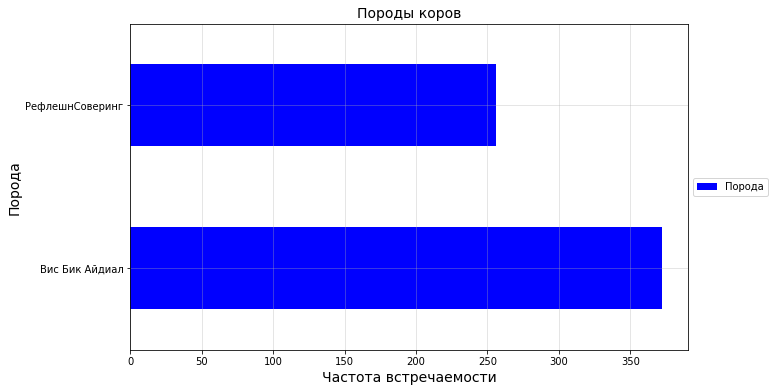

In [46]:
#Посмотрим на породы коров.
data = ferma_main[['Порода']]

data_grouped = data.groupby('Порода').size().rename('Частота встречаемости')

plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Порода')
plt.title("Породы коров", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Порода", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Видно, что коров породы "Вис Бик Айдиал" больше всего.

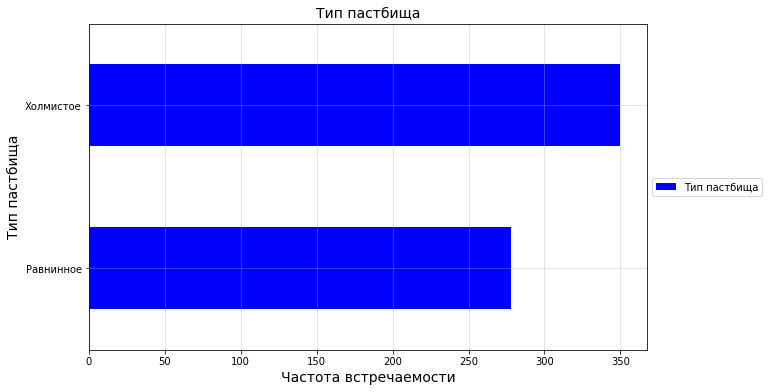

In [47]:
#Теперь по типам пастбищ.
data = ferma_main[['Тип пастбища']]


data_grouped = data.groupby('Тип пастбища').size().rename('Частота встречаемости')


plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Тип пастбища')
plt.title("Тип пастбища", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Тип пастбища", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Видим, что большинство пастбищ имеет холмистый тип.

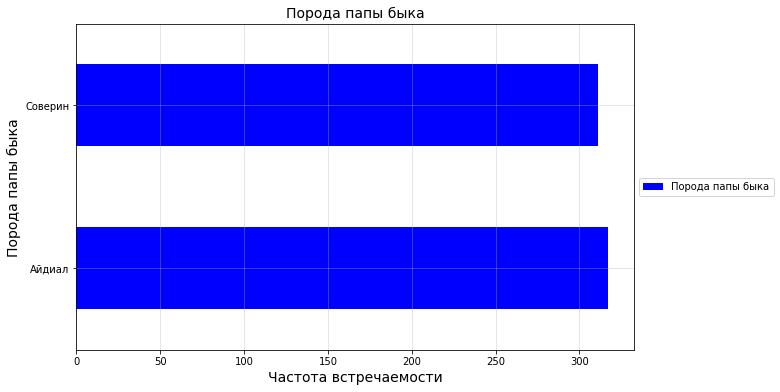

In [48]:
#По породе папы быка.
data = ferma_main[['Порода папы быка']]

data_grouped = data.groupby('Порода папы быка').size().rename('Частота встречаемости')

plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Порода папы быка')
plt.title("Порода папы быка", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Порода папы быка", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Породы папы быка представлены примерно в равной степени.

In [49]:
#Теперь посмотрим на Жирность,%.
ferma_main ['Жирность,%'].describe()

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: Жирность,%, dtype: float64

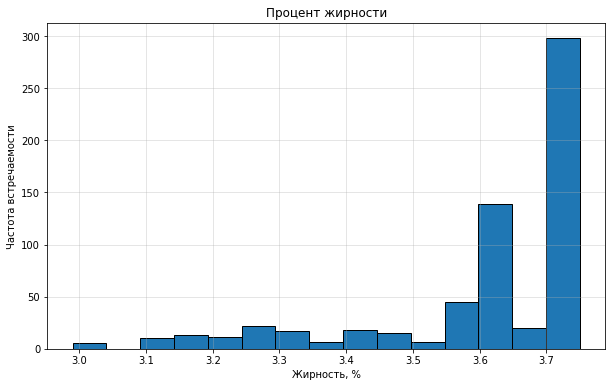

In [50]:
data = ferma_main ['Жирность,%']

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, edgecolor='black')
plt.title("Процент жирности")
plt.xlabel("Жирность, %")
plt.ylabel("Частота встречаемости")
plt.grid(axis='both', alpha=.4)
plt.show()

Основное значение "Жирность, %" находится в диапазоне от 3.6 до 3.72.

In [51]:
#Далее статистика для Белок,%.
ferma_main['Белок,%'].describe()

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: Белок,%, dtype: float64

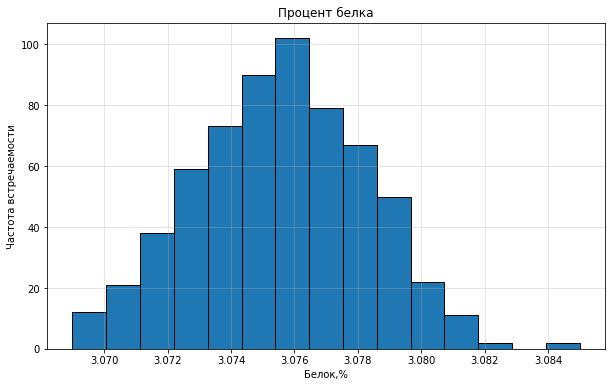

In [52]:
data = ferma_main['Белок,%']

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, edgecolor='black')
plt.title("Процент белка")
plt.xlabel("Белок,%")
plt.ylabel("Частота встречаемости")
plt.grid(axis='both', alpha=.4)
plt.show()

Процент белка имеет очень маленькую дисперсию, средняя величина составляет 3.075%.

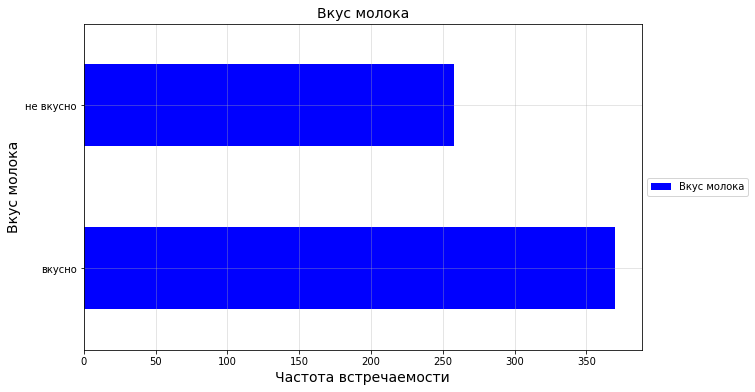

In [53]:
#Построим диаграмму для Вкуса молока.
data = ferma_main[['Вкус молока']]

data_grouped = data.groupby('Вкус молока').size().rename('Частота встречаемости')

plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Вкус молока')
plt.title("Вкус молока", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Вкус молока", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Диаграмма показывает, что основное количество молока у фермера обладает хорошим вкусом.

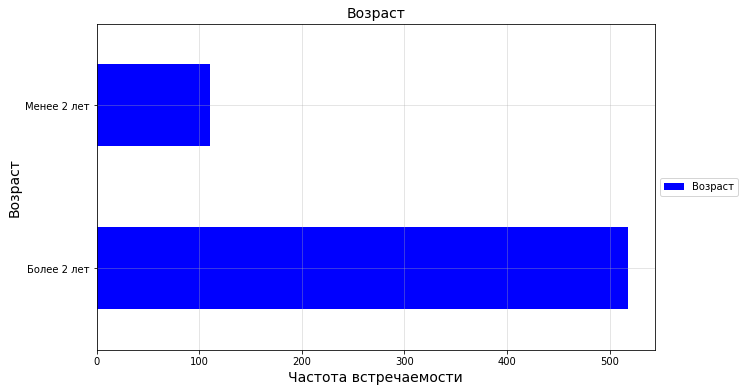

In [54]:
#Возраста коров.
data = ferma_main[['Возраст']]

data_grouped = data.groupby('Возраст').size().rename('Частота встречаемости')

plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Возраст')
plt.title("Возраст", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Возраст", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Можно увидеть, что большинство коров старше двух лет.

In [55]:
ferma_dad.head()

,id,Имя папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


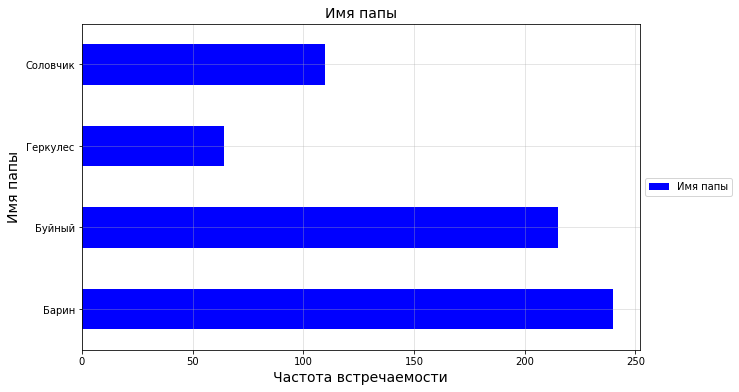

In [56]:
#Имена пап коров.
data = ferma_dad[['Имя папы']]

data_grouped = data.groupby('Имя папы').size().rename('Частота встречаемости')

plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Имя папы')
plt.title("Имя папы", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Имя папы", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Диаграмма показывает распределение коров по отцу: наибольшее число приходится на Барина, затем следуют Буйный, Соловчик и Геркулес.

Далее также поступим с файлом cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

In [57]:
cow_buy.head()

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


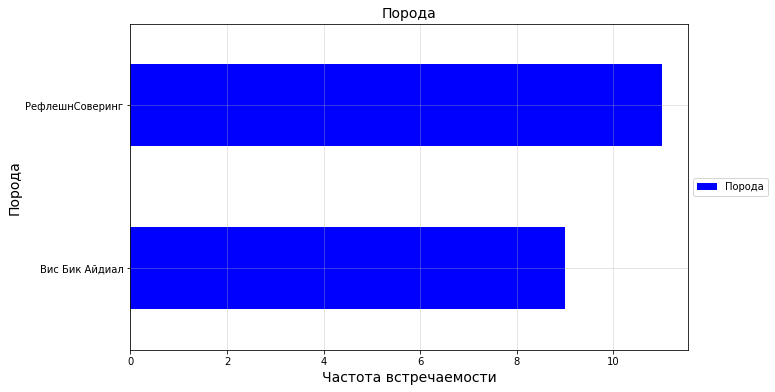

In [58]:
#Для пород коров.
data = cow_buy[['Порода']]

data_grouped = data.groupby('Порода').size().rename('Частота встречаемости')

plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Порода')
plt.title("Порода", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Порода", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Породы коров представлены примерно в равной степени.

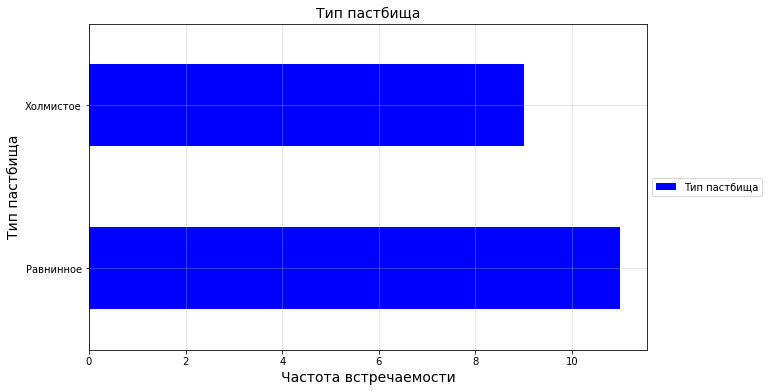

In [59]:
#По типам постабищ.
data = cow_buy[['Тип пастбища']]

data_grouped = data.groupby('Тип пастбища').size().rename('Частота встречаемости')

plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Тип пастбища')
plt.title("Тип пастбища", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Тип пастбища", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Распределение типов пастбищ также примерно равномерное.

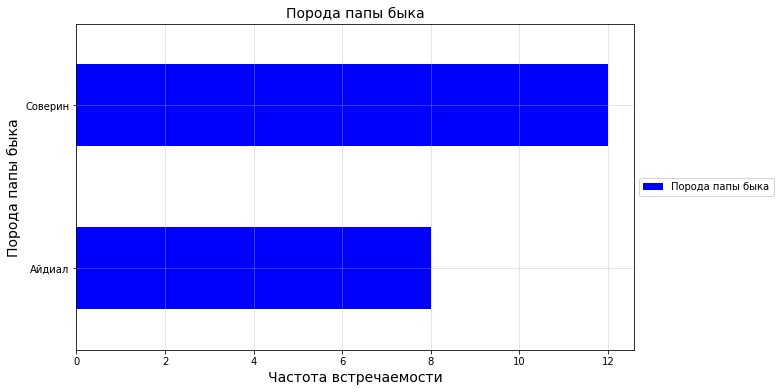

In [60]:
#По породе папы быка.
data = cow_buy[['Порода папы быка']]

data_grouped = data.groupby('Порода папы быка').size().rename('Частота встречаемости')

plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Порода папы быка')
plt.title("Порода папы быка", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Порода папы быка", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

График показывает, что порода папы быка Соверин встречается чаще всего.

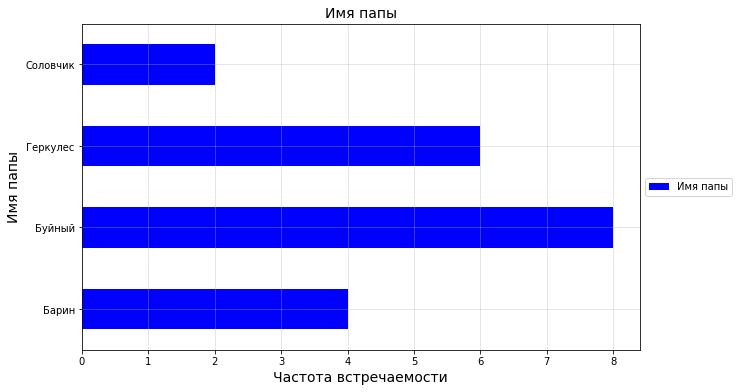

In [61]:
#Имя папы.
data = cow_buy[['Имя папы']]

data_grouped = data.groupby('Имя папы').size().rename('Частота встречаемости')

plt.figure(figsize=(10, 6))
data_grouped.plot.barh(color='blue', label='Имя папы')
plt.title("Имя папы", fontsize=14, fontweight="normal", color='black')
plt.xlabel("Частота встречаемости", fontsize=14, fontweight="normal", color='black')
plt.ylabel("Имя папы", fontsize=14, fontweight="normal", color='black')
plt.grid(axis='both', alpha=.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Среди пап коров первое место занимает Буйный, затем следует Геркулес, а после них идут Барин и Соловчик.

In [62]:
cow_buy['Жирность,%'].describe()

count    20.000000
mean      3.577500
std       0.126818
min       3.340000
25%       3.510000
50%       3.590000
75%       3.650000
max       3.770000
Name: Жирность,%, dtype: float64

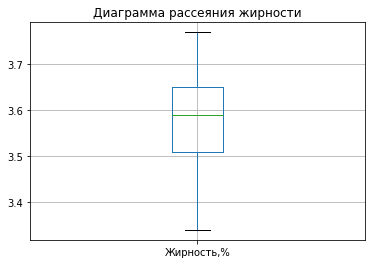

In [63]:
cow_buy.boxplot(column='Жирность,%')
plt.title('Диаграмма рассеяния жирности')
plt.show()

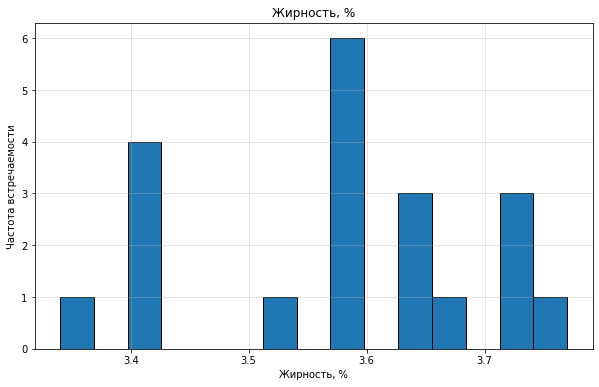

In [64]:
data = cow_buy['Жирность,%']

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, edgecolor='black')
plt.title("Жирность, %")
plt.xlabel("Жирность, %")
plt.ylabel("Частота встречаемости")
plt.grid(axis='both', alpha=.4)
plt.show()

"Ящик с усами" показывает отсутствие выбросов. Основные значения находятся в диапазоне от 3.4 до 3.7.

In [65]:
cow_buy['Белок,%'].describe()

count    20.000000
mean      3.069500
std       0.010339
min       3.046000
25%       3.064000
50%       3.074000
75%       3.076000
max       3.081000
Name: Белок,%, dtype: float64

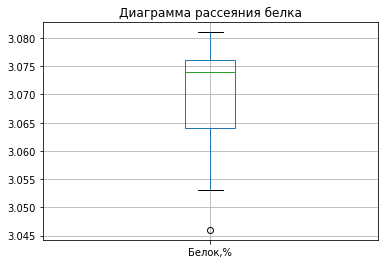

In [66]:
cow_buy.boxplot(column='Белок,%')
plt.title('Диаграмма рассеяния белка')
plt.show()

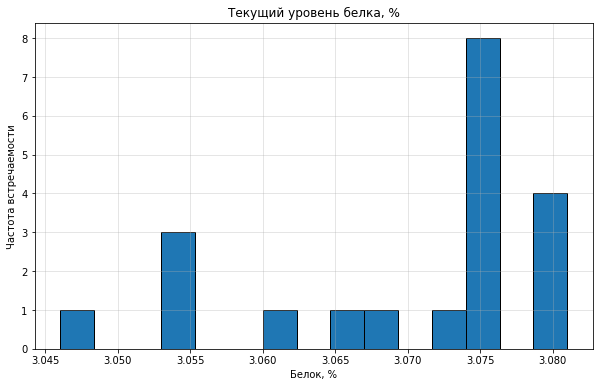

In [67]:
data = cow_buy['Белок,%']

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, edgecolor='black')
plt.title("Текущий уровень белка, %")
plt.xlabel("Белок, %")
plt.ylabel("Частота встречаемости")
plt.grid(axis='both', alpha=.4)
plt.show()

"Ящик с усами" показывает отсутствие выбросов. Гистограмма демонстрирует ненормальное распределение данных. Основные значения находятся в диапазоне от 3.06 до 3.8, с очень низким стандартным отклонением.

Вывод: в данных был обнаружен только один выброс, который находился в столбце удой в таблице фермера. Этот выброс был удален. Количественные данные характеризуются ненормальным распределением. Для стада фермера характерны следующие особенности:

* Медиана удоя превышает 6000 кг.

* Преобладают коровы породы "Вис Бик Айдиал".

* Холмистый тип пастбища является наиболее распространенным.

* Большая часть молока у фермера имеет хороший вкус.

* Большинство коров старше 2 лет.

* Таблица с именами папы коровы показывает следующее распределение: первое место занимает Барин, второе - Буйный, третье - Соловчик, четвертое - Геркулес.

* В "Экоферме" породы коров распределены равномерно.

* Тип пастбищ также имеет равномерное распределение.

* Порода папы быка Соверин встречается чаще всего.

* Среди пап коров первое место занимает Буйный, второе - Геркулес, далее следуют Барин и Соловчик с примерно одинаковыми показателями.

## Шаг 4. Корреляционный анализ

In [68]:
def my_corr_Pearson(a, b, c):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(a[b], a[c], marker='o', facecolors='none', edgecolors='blue')
    corr1 = round(a[c].corr(a[b]), 3)
    ax.set_xlabel(f'{b}\n\nКоэффициент корреляции Пирсона = {corr1}', fontsize=14, fontweight="normal", color='black')
    ax.set_ylabel(f'{c}', fontsize=14, fontweight="normal", color='black')
    title = f'Диаграммы рассеяния между\n {b} и {c}'
    ax.set_title(title, fontsize=14, fontweight="normal", color='black')
    plt.show()

In [69]:
def my_corr_Spearman(a, b, c):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(a[b], a[c], marker='o', facecolors='none', edgecolors='blue')
    corr_spearman, a_corr_spearman = spearmanr(a[b], a[c])
    ax.set_xlabel(f'{b}\n\nКоэффициент корреляции Спирмена = {round(corr_spearman, 3)}\n\nЗначение p = {a_corr_spearman}', fontsize=14, fontweight="normal", color='black')
    ax.set_ylabel(f'{c}', fontsize=14, fontweight="normal", color='black')
    title = f'Диаграммы рассеяния между\n {b} и {c}'
    ax.set_title(title, fontsize=14, fontweight="normal", color='black')
    plt.show()

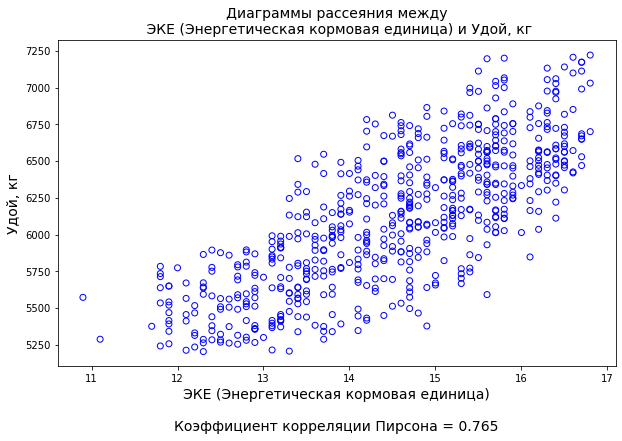

In [70]:
a = ferma_main
b = 'ЭКЕ (Энергетическая кормовая единица)'
c = 'Удой, кг'
my_corr_Pearson(a, b, c)

Анализ показал сильную линейную взаимосвязь между ЭКЕ и удоями.

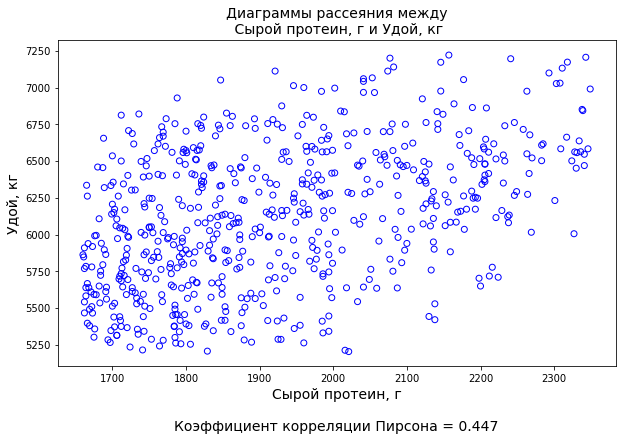

In [71]:
a = ferma_main
b = 'Сырой протеин, г'
c = 'Удой, кг'
my_corr_Pearson(a, b, c)

Анализ показал слабую линейную взаимосвязь между содержанием сырого протеина и удоями.

Используем метод корреляции Спирмена. Этот статистический метод количественно оценивает степень, в которой ранжированные переменные связаны монотонной функцией, то есть когда одна переменная увеличивается или уменьшается вместе с другой. Метод предполагает, что выборки некоррелированы (не отвергают 𝐻0).

Функция принимает два реальных набора данных в качестве аргументов и возвращает как коэффициент корреляции в диапазоне от -1 до 1, так и значение 𝑝, которое помогает интерпретировать значимость коэффициента.

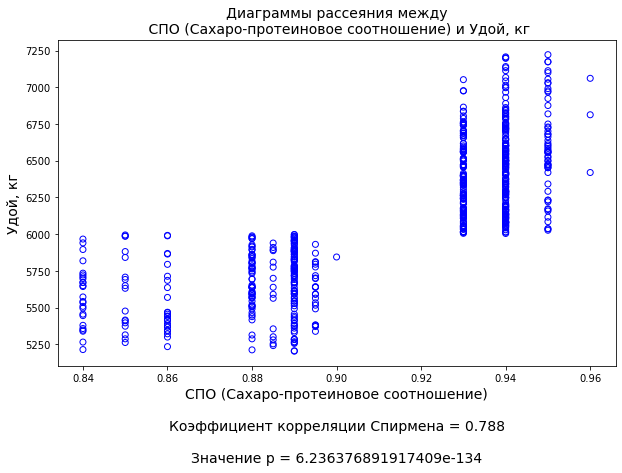

In [72]:
a = ferma_main
b = 'СПО (Сахаро-протеиновое соотношение)'
c = 'Удой, кг'
my_corr_Spearman(a, b, c)

Статистический тест указывает на высокую положительную корреляцию с коэффициентом 0.787. Значение 𝑝 приближено к нулю, что говорит о том, что наблюдение таких данных при условии отсутствия корреляции крайне маловероятно (например, с вероятностью 95%). Это позволяет нам отвергнуть нулевую гипотезу о том, что выборки не коррелированы.

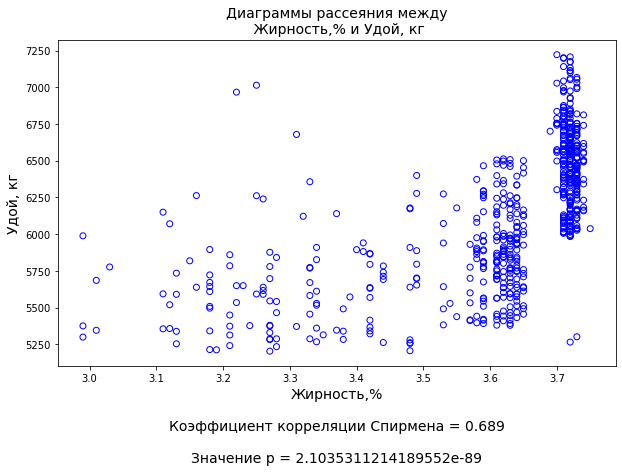

In [73]:
a = ferma_main
b = 'Жирность,%'
c = 'Удой, кг'
my_corr_Spearman(a, b, c)

Статистический тест указывает на среднюю положительную корреляцию с коэффициентом 0.689. Значение 𝑝 приближено к нулю, что говорит о том, что наблюдение таких данных при условии отсутствия корреляции крайне маловероятно (например, с вероятностью 95%). Это позволяет нам отвергнуть нулевую гипотезу о том, что выборки не коррелированы.

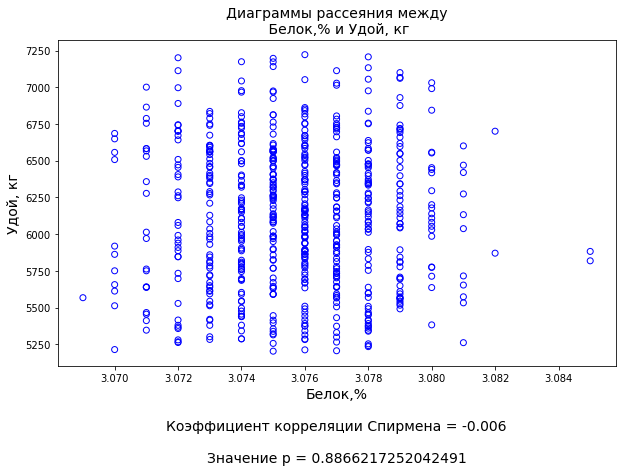

In [74]:
a = ferma_main
b = 'Белок,%'
c = 'Удой, кг'
my_corr_Spearman(a, b, c)

Статистический тест указывает на очень слабую отрицательную корреляцию с коэффициентом -0.006. Значение 𝑝 не приближено к нулю, что говорит о том, что наблюдение таких данных при условии отсутствия корреляции вероятно (например, с вероятностью 95%). Это не позволяет нам отвергнуть нулевую гипотезу о том, что выборки не коррелированы.

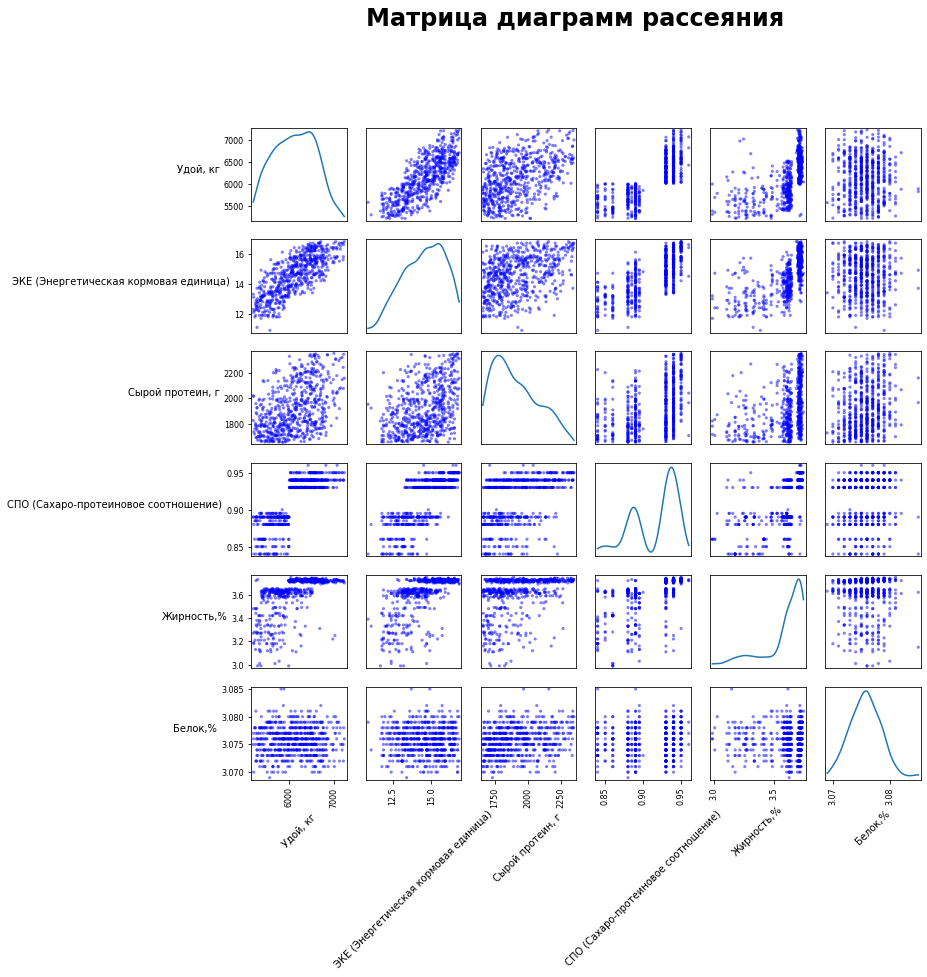

In [75]:
axes = pd.plotting.scatter_matrix(
    ferma_main[ferma_main.columns[ferma_main.columns != 'id']], 
    figsize=(12, 12),          
    diagonal='kde',            
    alpha=0.5,                 
    color='blue',              
    s=40                       
)

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)    
    ax.xaxis.label.set_fontsize(10)    
    ax.yaxis.label.set_rotation(0)     
    ax.yaxis.label.set_ha('right')     
    ax.yaxis.label.set_fontsize(10)    

plt.suptitle(
    'Матрица диаграмм рассеяния', 
    fontsize=24, 
    fontweight='bold', 
    color='black', 
    y=1.02    
)

plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.show()

Вывод: 
* Анализ показал, что зависимость удоев молока от ЭКЕ и содержания сырого протеина носит линейный характер;

* Зависимость удоев от других факторов нелинейная;

In [76]:
type(data)

pandas.core.series.Series

In [77]:
data = data.to_frame()

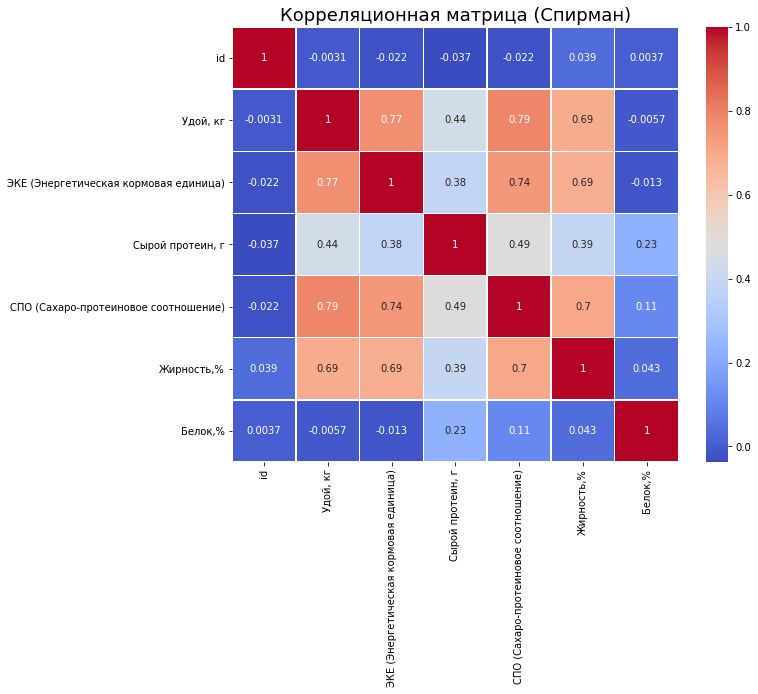

In [78]:
spearman_corr = ferma_main.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица (Спирман)', fontsize=18)
plt.show()

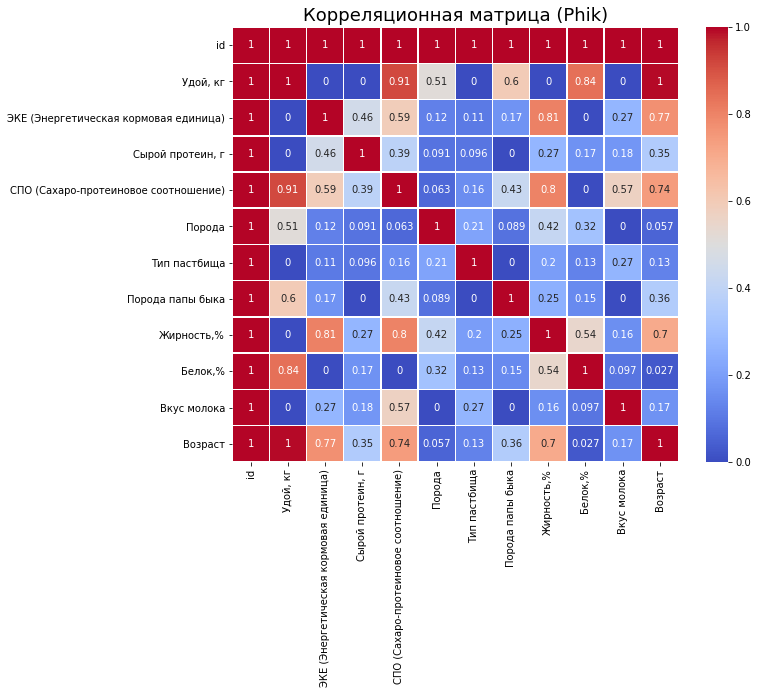

In [79]:
interval_cols = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)']

phik_corr = ferma_main.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица (Phik)', fontsize=18)
plt.show()

Сделана **корреляционная матрица Phik**. Давайте посмотрим на некоторые ключевые моменты:

1. **Удой, кг**:
   - Имеет высокую корреляцию с показателем **Жирность, %** (0.84). Это означает, что между удоем и жирностью молока существует значительная связь, вероятно линейная или близкая к ней.
   - Также коррелирует с **СОП (Сахаро-протеиновое соотношение)** (0.91) и **Белок, %** (0.84). Эти признаки могут напрямую влиять на качество молока и его удой.

2. **ЭКЕ (Энергетическая кормовая единица)**:
   - Умеренно коррелирует с **СОП** (0.59), **Сырой протеин, г** (0.46) и **Удой, кг** (0.46). ЭКЕ может быть важным фактором, влияющим на продуктивность животных.
   - Присутствует более слабая корреляция с **Жирностью** (0.27) и **Белком** (0.47).

3. **СОП (Сахаро-протеиновое соотношение)**:
   - Имеет сильную корреляцию с **Удой, кг** (0.91), что подтверждает важность этого показателя в продуктивности животных.
   - Высокая корреляция с **Белком, %** (0.74) и **Жирностью, %** (0.57) указывает на влияние на состав молока.

4. **Порода**:
   - Наиболее заметная корреляция с **ЭКЕ** (0.51) и **Жирностью** (0.41), что может говорить о различиях в продуктивности и составе молока у разных пород.

5. **Жирность, %**:
   - Высокая корреляция с **Удой** (0.84), **Белок, %** (0.64) и **СОП** (0.57). Жирность молока является одним из важнейших показателей качества и тесно связана с продуктивностью.

6. **Белок, %**:
   - Сильно коррелирует с **Удой, кг** (0.84), **Жирностью** (0.64) и **СОП** (0.74). Это подчеркивает важность белкового состава в производстве молока.

7. **Порода папы быка**:
   - Имеет низкие корреляции с большинством признаков, что может указывать на меньшую зависимость производительности от этого фактора по сравнению с другими.


##  Шаг 5. Обучение модели линейной регрессии

Построим модель линейной регрессии на основе данных из файла ferma_main.csv. Целевой признак будет Удой.

In [80]:
def prepare_data_and_model(a, b, c, d):
    RANDOM_STATE = 42
    
    X = a.drop(b, axis=1)
    y = a[b]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE)
    
    cat_col_names = c
    num_col_names = d
    
    encoder = OneHotEncoder(drop='first', sparse=False) 
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    
    encoder_col_names = encoder.get_feature_names() #get_feature_names_out()
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])
    
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
     
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    predictions = model_lr.predict(X_test)
    
    return [X_train, X_test, y_train, y_test, predictions, encoder, scaler, model_lr]

In [81]:
def calculate_r2_linear_regression(func, a, b, c, d):
    func_results = func(a, b, c, d)
    r2_lr = r2_score(func_results[3], func_results[4])
    
    print("\x1b[38;5;19m", "R² LinearRegression = ", r2_lr, "\x1b[0m")

In [82]:
def calculate_mse_linear_regression(func, a, b, c, d):
    func_results = func(a, b, c, d)
    mse = mean_squared_error(func_results[3], func_results[4])
    
    print("\x1b[38;5;19m", "MSE LinearRegression = ", mse, "\x1b[0m")

In [83]:
def calculate_mae_linear_regression(func, a, b, c, d):
    func_results = func(a, b, c, d)
    mae = mean_absolute_error(func_results[3], func_results[4])
    
    print("\x1b[38;5;19m", "MAE LinearRegression = ", mae, "\x1b[0m")

In [84]:
def calculate_rmse_linear_regression(func, a, b, c, d):
    func_results = func(a, b, c, d)
    rmse = mean_squared_error(func_results[3], func_results[4], squared=False)
    
    print("\x1b[38;5;19m", "RMSE LinearRegression = ", rmse, "\x1b[0m")

In [85]:
def visualize_residual_analysis(func, a, b, c, d):
    func_results = func(a, b, c, d)
    residuals = func_results[3] - func_results[4] 
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
    axes[0].hist(residuals, bins=100, color = 'blue')
    axes[0].set_title('Гистограмма распределения остатков', fontsize=14, fontweight="normal", color='black')
    axes[0].set_xlabel('Остатки', fontsize=14, fontweight="normal", color='black')

    axes[1].scatter(x=func_results[4],  y=residuals, color = 'blue')
    axes[1].set_xlabel('Предсказания модели', fontsize=14, fontweight="normal", color='black')
    axes[1].set_ylabel('Остатки', fontsize=14, fontweight="normal", color='black')
    axes[1].set_title('Анализ дисперсии', fontsize=14, fontweight="normal", color='black')
    plt.show()

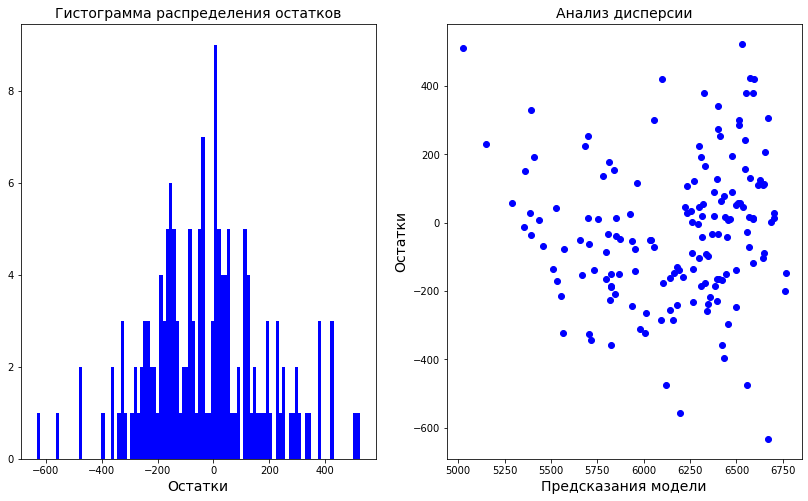

 R² LinearRegression =  0.7844078173416967 
 MSE LinearRegression =  43887.015009660514 
 MAE LinearRegression =  164.24194463474925 
 RMSE LinearRegression =  209.4922791170608 


In [86]:
a = ferma_main

b = 'Удой, кг'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
d = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)']

func = prepare_data_and_model
func_results = func(a, b, c, d)

visualize_residual_analysis(func, a, b, c, d)

calculate_r2_linear_regression(func, a, b, c, d)
calculate_mse_linear_regression(func, a, b, c, d)
calculate_mae_linear_regression(func, a, b, c, d)
calculate_rmse_linear_regression(func, a, b, c, d)

1. **Гистограмма остатков**:
   - Остатки в основном распределены около нуля, что хорошо.
   - Однако распределение не идеальное: есть выбросы, особенно в диапазоне от -600 до +400, что может указывать на аномалии или недостатки модели.

2. **График остатков против предсказаний**:
   - Остатки разбросаны без явных паттернов, что указывает на отсутствие систематических ошибок.
   - Однако есть несколько выбросов, которые показывают, что модель иногда ошибается на больших значениях.


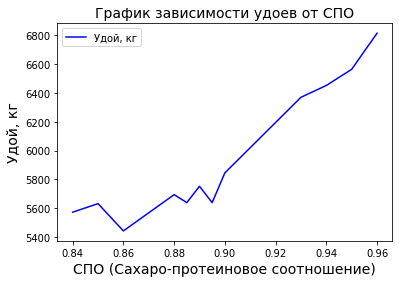

In [87]:
ferma_main.pivot_table(index='СПО (Сахаро-протеиновое соотношение)', values='Удой, кг', aggfunc='median').plot(color = 'blue')
plt.xlabel('СПО (Сахаро-протеиновое соотношение)', fontsize=14, fontweight="normal", color='black')
plt.ylabel('Удой, кг', fontsize=14, fontweight="normal", color='black')
plt.title('График зависимости удоев от СПО', fontsize=14, fontweight="normal", color='black')
plt.show()

Анализируя график зависимости удоев от Сахаро-протеинового соотношения (СПО), мы замечаем, что значение 0.9 является точкой перехода от линейного к нелинейному поведению. Мы можем классифицировать СПО как категориальный признак, учитывая эту границу нелинейности.

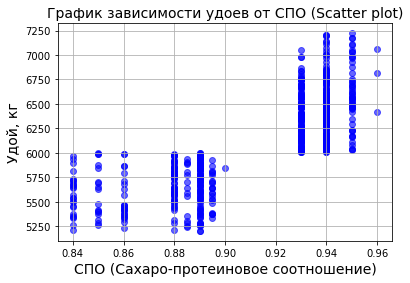

In [88]:
plt.scatter(ferma_main['СПО (Сахаро-протеиновое соотношение)'], ferma_main['Удой, кг'], color='blue', alpha=0.6)
plt.xlabel('СПО (Сахаро-протеиновое соотношение)', fontsize=14, fontweight="normal", color='black')
plt.ylabel('Удой, кг', fontsize=14, fontweight="normal", color='black')
plt.title('График зависимости удоев от СПО (Scatter plot)', fontsize=14, fontweight="normal", color='black')
plt.grid(True)
plt.show()

По мере увеличения СПО (Сахаро-протеиновое соотношение) от 0.00 до 1.00, удой от 6000 до 7000.

In [89]:
cpo_mean = ferma_main['СПО (Сахаро-протеиновое соотношение)'].mean()
ferma_main['СПО (Сахаро-протеиновое соотношение)'] = ferma_main['СПО (Сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.9 else 0)

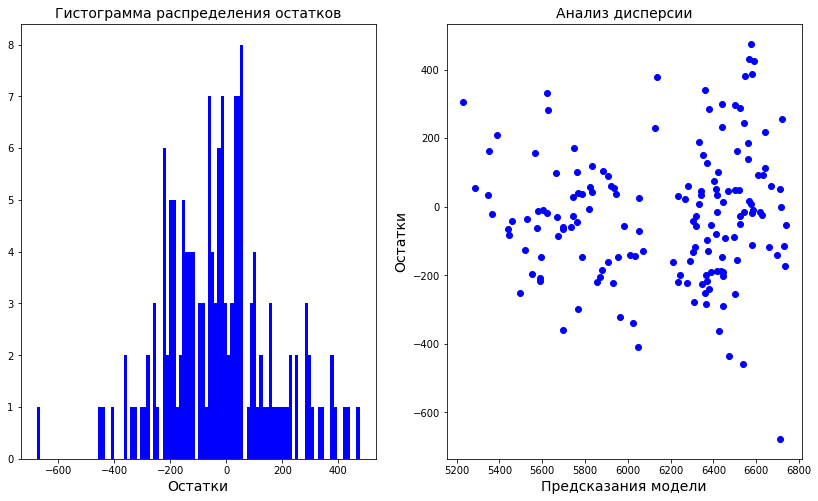

 R² LinearRegression =  0.8180879926867501 
 MSE LinearRegression =  37030.91131113695 
 MAE LinearRegression =  149.03965222364602 
 RMSE LinearRegression =  192.43417396901452 


In [90]:
ferma_main['ЭКЕ в квадрате'] = ferma_main['ЭКЕ (Энергетическая кормовая единица)']**2
a = ferma_main
b = 'Удой, кг'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО (Сахаро-протеиновое соотношение)']
d = ['ЭКЕ в квадрате', 'Сырой протеин, г']

func = prepare_data_and_model
func_results = func(a, b, c, d)

visualize_residual_analysis(func, a, b, c, d)

calculate_r2_linear_regression(func, a, b, c, d)
calculate_mse_linear_regression(func, a, b, c, d)
calculate_mae_linear_regression(func, a, b, c, d)
calculate_rmse_linear_regression(func, a, b, c, d)

1. **Гистограмма распределения остатков**:
   - Распределение остатков близко к нормальному, что свидетельствует о хорошей работе модели.
   - Наблюдается легкая асимметрия: распределение слегка сдвинуто в положительную сторону, указывая на недооценку некоторых значений.

2. **График анализа дисперсии**:
   - Остатки распределены случайным образом без заметной зависимости от предсказанных значений, что является хорошим признаком.

Модель демонстрирует хорошие результаты: остатки распределены нормально, и на графике дисперсии нет явной зависимости от предсказаний. 

Построим модель линейной регрессии, включив новый признак "Имя папы" из файла ferma_dad.csv.

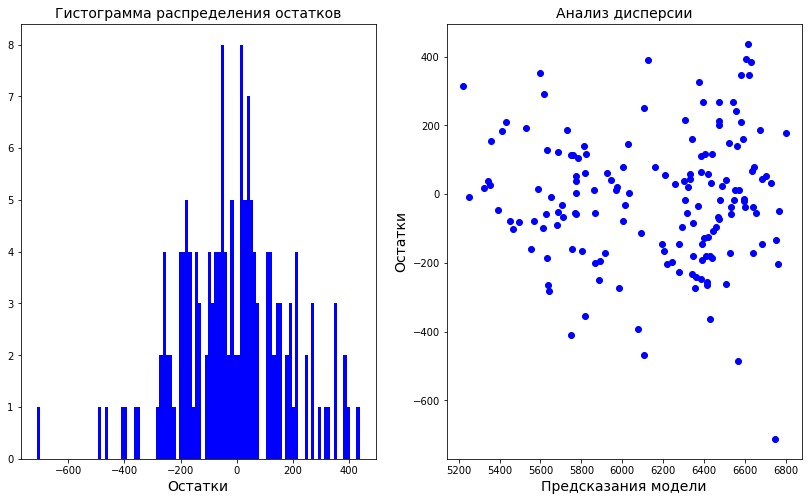

 R² LinearRegression =  0.8247542745210406 
 MSE LinearRegression =  35673.88988618195 
 MAE LinearRegression =  146.16302445362322 
 RMSE LinearRegression =  188.8753289505592 


In [91]:
ferma_main_dad = pd.merge(ferma_main, ferma_dad) 
a = ferma_main_dad
b = 'Удой, кг'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО (Сахаро-протеиновое соотношение)', 'Имя папы']
d = ['ЭКЕ в квадрате', 'Сырой протеин, г']
func = prepare_data_and_model
func_results = func(ferma_main_dad, b, c, d)

visualize_residual_analysis(func, ferma_main_dad, b, c, d)

calculate_r2_linear_regression(func, ferma_main_dad, b, c, d)
calculate_mse_linear_regression(func, ferma_main_dad, b, c, d)
calculate_mae_linear_regression(func, ferma_main_dad, b, c, d)
calculate_rmse_linear_regression(func, ferma_main_dad, b, c, d)

Анализ показал, что последняя модель имеет более высокое значение 𝑅2(0.82), что ближе к идеальному значению 1. Метрики 𝑀𝑆𝐸, 𝑀𝐴𝐸 и 𝑅𝑀𝑆𝐸 также указывают на меньшие ошибки в этой модели.

In [92]:
cow_buy['ЭКЕ (Энергетическая кормовая единица)'] = ferma_main['ЭКЕ (Энергетическая кормовая единица)'].mean()*1.05
cow_buy['ЭКЕ в квадрате'] = cow_buy['ЭКЕ (Энергетическая кормовая единица)']**2
cow_buy['Сырой протеин, г'] = ferma_main['Сырой протеин, г'].mean()*1.05
cow_buy['СПО (Сахаро-протеиновое соотношение)'] = cpo_mean*1.05
cow_buy['Возраст'] = 'менее_2_лет'
cow_buy['Удой, кг'] = 0
cow_buy['СПО (Сахаро-протеиновое соотношение)'] = cow_buy['СПО (Сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.9 else 0)
cow_buy['Возраст'] = cow_buy['Возраст'].apply(lambda x: 1 if x == 'Более 2 лет' else 0)
display(cow_buy)

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг"
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,0,15.276162,233.361138,2019.947532,1,0
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,15.276162,233.361138,2019.947532,1,0
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,0,15.276162,233.361138,2019.947532,1,0
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,0,15.276162,233.361138,2019.947532,1,0
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,0,15.276162,233.361138,2019.947532,1,0
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,15.276162,233.361138,2019.947532,1,0
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,0,15.276162,233.361138,2019.947532,1,0
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,0,15.276162,233.361138,2019.947532,1,0
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,0,15.276162,233.361138,2019.947532,1,0
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,15.276162,233.361138,2019.947532,1,0


In [93]:
ferma_main_dad['Возраст'] = ferma_main_dad['Возраст'].apply(lambda x: 1 if x == 'Более 2 лет' else 0)
ferma_main_dad.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст,ЭКЕ в квадрате,Имя папы
0,1,5863,14.2,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,1,201.64,Буйный
1,2,5529,12.8,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,0,163.84,Соловчик
2,3,5810,14.0,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,1,196.00,Барин
3,4,5895,12.4,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,1,153.76,Буйный
4,5,5302,12.8,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,0,163.84,Барин


Применив лучшую по качеству и точности модель к данным из файла cow_buy.csv, мы сможем предсказать удои коров, которых фермер планирует купить у "Экофермы".

In [94]:
X_train = ferma_main_dad
X_test = cow_buy

target = 'Удой, кг'
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО (Сахаро-протеиновое соотношение)', 'Имя папы']
num_col_names = ['ЭКЕ в квадрате', 'Сырой протеин, г']


X = X_train.drop(target, axis=1)
y = X_train[target]

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) 
X_ohe = encoder.fit_transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names() #get_feature_names_out()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)
                  
model_lr  = LinearRegression()
model_lr.fit(X, y) 

X = X_test.drop(target, axis=1)
y = X_test[target]

X_ohe = encoder.transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names() #get_feature_names_out()

X_scaled = scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X_cow = pd.concat([X_ohe, X_scaled], axis=1)   

predictions = model_lr.predict(X_cow)

cow_buy = cow_buy.reset_index(drop=True)
#print(predictions)

for i in range(len(cow_buy['Удой, кг'])):
    cow_buy.loc[i,'Удой, кг'] = predictions[i]
#cow_buy

display(cow_buy.sort_values(by = 'Удой, кг', ascending = False))  

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг"
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,0,15.276162,233.361138,2019.947532,1,6370.5
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,0,15.276162,233.361138,2019.947532,1,6370.5
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,15.276162,233.361138,2019.947532,1,6370.5
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,0,15.276162,233.361138,2019.947532,1,6364.5
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,0,15.276162,233.361138,2019.947532,1,6364.5
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,15.276162,233.361138,2019.947532,1,6364.5
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,0,15.276162,233.361138,2019.947532,1,6359.5
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,0,15.276162,233.361138,2019.947532,1,6359.5
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,0,15.276162,233.361138,2019.947532,1,6359.5
18,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,0,15.276162,233.361138,2019.947532,1,6319.5


In [95]:
X_train = ferma_main_dad
X_test = cow_buy

target = 'Удой, кг'
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО (Сахаро-протеиновое соотношение)', 'Имя папы']
num_col_names = ['ЭКЕ в квадрате', 'Сырой протеин, г']

X = X_train.drop(target, axis=1)
y = X_train[target]

encoder = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')  
X_ohe = encoder.fit_transform(X[cat_col_names])

if hasattr(encoder, 'get_feature_names_out'):
    encoder_col_names = encoder.get_feature_names_out(cat_col_names)  
else:
    encoder_col_names = encoder.get_feature_names(cat_col_names)  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)

model_lr = LinearRegression()
model_lr.fit(X, y)

X = X_test.drop(target, axis=1)
y = X_test[target]

X_ohe = encoder.transform(X[cat_col_names])
X_scaled = scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X_cow = pd.concat([X_ohe, X_scaled], axis=1)

predictions = model_lr.predict(X_cow)

cow_buy = cow_buy.reset_index(drop=True)

for i in range(len(cow_buy['Удой, кг'])):
    cow_buy.loc[i, 'Удой, кг'] = predictions[i]

display(cow_buy.sort_values(by='Удой, кг', ascending=False))

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг"
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,15.276162,233.361138,2019.947532,1,6375.747238
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,0,15.276162,233.361138,2019.947532,1,6375.747238
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,0,15.276162,233.361138,2019.947532,1,6375.747238
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,0,15.276162,233.361138,2019.947532,1,6371.351509
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,15.276162,233.361138,2019.947532,1,6371.351509
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,0,15.276162,233.361138,2019.947532,1,6371.351509
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,0,15.276162,233.361138,2019.947532,1,6365.761058
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,0,15.276162,233.361138,2019.947532,1,6365.761058
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,0,15.276162,233.361138,2019.947532,1,6365.761058
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,0,15.276162,233.361138,2019.947532,1,6327.206675


In [96]:
cow_buy.sort_values (by = ['Удой, кг'], ascending = False).loc[cow_buy['Удой, кг'] >= 6000]

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг"
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,15.276162,233.361138,2019.947532,1,6375.747238
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,0,15.276162,233.361138,2019.947532,1,6375.747238
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,0,15.276162,233.361138,2019.947532,1,6375.747238
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,0,15.276162,233.361138,2019.947532,1,6371.351509
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,15.276162,233.361138,2019.947532,1,6371.351509
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,0,15.276162,233.361138,2019.947532,1,6371.351509
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,0,15.276162,233.361138,2019.947532,1,6365.761058
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,0,15.276162,233.361138,2019.947532,1,6365.761058
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,0,15.276162,233.361138,2019.947532,1,6365.761058
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,0,15.276162,233.361138,2019.947532,1,6327.206675


Выводы: 
* Построены модели линейной регрессии на данных из файла farm_main.csv, и среди них выбрана наиболее точная по значениям метрик.

* Коэффициент детерминации 𝑅2 в лучшей модели равен 0.82, что ближе к идеальному значению 1.

* Эта модель была применена к данным из файла cow_buy.csv для прогнозирования удоев коров.

* Были определены 20 коров из ассоциации пастбищ "ЭкоФерма" с прогнозируемыми удоями не менее 6000 кг в год.

Построим модель логистической регрессии на основе данных из файла farm_main.csv. Целевым признаком будет Вкус молока. Создадим матрицу ошибок для оценки модели.

In [97]:
ferma_main['Возраст'] = ferma_main['Возраст'].apply(lambda x: 1 if x == 'Более 2 лет' else 0)
ferma_main['Вкус молока'] = ferma_main['Вкус молока'].apply(lambda x: 1 if x == 'вкусно' else 0)
cow_buy['Вкус молока'] = 0

 Accuracy =  0.6242038216560509 
 Precision =  0.6198347107438017 
 Recall =  0.8522727272727273 


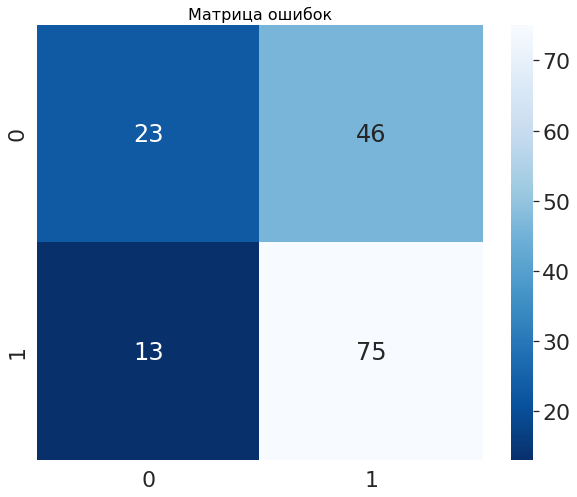

In [98]:
a = ferma_main
b = 'Вкус молока'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
d = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 
     'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%' , 'Белок,%']

RANDOM_STATE = 42

X = a.drop(b, axis=1)
y = a[b]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

cat_col_names = c
num_col_names = d

encoder = OneHotEncoder(drop='first', sparse=False) 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names() 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)  
precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)       

plt.figure(figsize = (10,8))
cm = confusion_matrix(y_test, y_pred)

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.title('Матрица ошибок', fontsize=16, fontweight="normal", color='black')
print('\u001b[38;5;19m', 'Accuracy = ',acc,'\u001b[0m')
print('\u001b[38;5;19m', 'Precision = ',precision,'\u001b[0m')
print('\u001b[38;5;19m', 'Recall = ',recall,'\u001b[0m')

Проведенный анализ показал, что значение Recall (объём) больше Precision (точность). При покупке коров критично важна минимизация ложно-положительных ошибок. В настоящее время модель допускает 46 случаев такой ошибки. Рассмотрим метрики для ситуации, когда критическая ошибка будет равна нулю.

In [99]:
a = ferma_main
b = 'Вкус молока'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
d = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 
     'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%' , 'Белок,%']

RANDOM_STATE = 42

X = a.drop(b, axis=1)
y = a[b]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

cat_col_names = c
num_col_names = d

encoder = OneHotEncoder(drop='first', sparse=False) 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names() 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)  

y_proba = clf.predict_proba(X_test)[:,1]  #[:,1] > porog     #cow_buy['pred_proba'] = clf.predict_proba(X_cow)[:,1] > 0.66

data = pd.DataFrame(zip(y_test, y_proba, y_pred), columns = ['y_valid', 'y_proba', 'y_pred']).sort_values(by='y_proba',ascending=False)

display(data) 

,y_valid,y_proba,y_pred
66,1,0.835375,1
85,1,0.834565,1
51,1,0.831855,1
110,1,0.824944,1
146,1,0.814454,1
...,...,...,...
23,1,0.310728,0
144,0,0.293429,0
119,0,0.284055,0
141,0,0.280745,0


In [100]:
y_pred = clf.predict(X_test)  
y_proba = clf.predict_proba(X_test)[:, 1]

data = pd.DataFrame(zip(y_test, y_proba, y_pred), columns=['y_valid', 'y_proba', 'y_pred']).sort_values(by='y_proba', ascending=False)

display(data)

,y_valid,y_proba,y_pred
66,1,0.835375,1
85,1,0.834565,1
51,1,0.831855,1
110,1,0.824944,1
146,1,0.814454,1
...,...,...,...
23,1,0.310728,0
144,0,0.293429,0
119,0,0.284055,0
141,0,0.280745,0


In [101]:
thresholds = np.linspace(0.1, 1, num=2000, endpoint=False)
thresholds = [round(i, 2) for i in thresholds]

In [102]:
columns = []

for i in thresholds:
    column_name = 'y_pred_{}'.format(i)
    columns.append(column_name)
    data[column_name] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

display(data.head())

,y_valid,y_proba,y_pred,y_pred_0.1,y_pred_0.11,y_pred_0.12,y_pred_0.13,y_pred_0.14,y_pred_0.15,y_pred_0.16,...,y_pred_0.91,y_pred_0.92,y_pred_0.93,y_pred_0.94,y_pred_0.95,y_pred_0.96,y_pred_0.97,y_pred_0.98,y_pred_0.99,y_pred_1.0
66,1,0.835375,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
85,1,0.834565,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
51,1,0.831855,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
110,1,0.824944,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
146,1,0.814454,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [103]:
for i in thresholds:
    cm = confusion_matrix(y_test, data['y_pred_'+str(i)])
    if cm[0][1] == 0:
        print('\u001b[38;5;19m', 'Порог = ',i ,'Precision = ', round(precision_score(y_test, data['y_pred_'+str(i)]), 2), 'TP =', cm[1][1])
        porog = i
        break

 Порог =  0.83 Precision =  1.0 TP = 3


 Accuracy =  0.46 
 Precision =  1.0 
 Recall =  0.03 


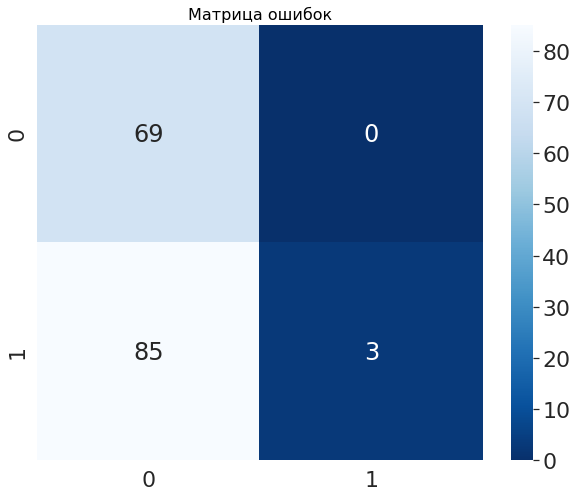

In [104]:
acc = round(accuracy_score(y_test, data['y_pred_'+str(porog)]), 2)
precision = round(precision_score(y_test, data['y_pred_'+str(porog)]), 2)
recall = round(recall_score(y_test, data['y_pred_'+str(porog)]), 2)

plt.figure(figsize = (10,8))
cm = confusion_matrix(y_test, data['y_pred_'+str(porog)])

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.title('Матрица ошибок', fontsize=16, fontweight="normal", color='black')
print("\x1b[38;5;19m", "Accuracy = ", acc, "\x1b[0m")
print("\x1b[38;5;19m", "Precision = ", precision, "\x1b[0m")
print("\x1b[38;5;19m", "Recall = ", recall, "\x1b[0m") 

In [105]:
X_train = ferma_main_dad
X_test = cow_buy

target = 'Вкус молока'
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
num_col_names = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 
     'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%' , 'Белок,%']

X = X_train.drop(target, axis=1)
y = X_train[target]

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_ohe = encoder.fit_transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)
                  
clf = LogisticRegression()
clf = clf.fit(X, y)

X = X_test.drop(target, axis=1)
y = X_test[target]

X_ohe = encoder.transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names()

X_scaled = scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X_cow = pd.concat([X_ohe, X_scaled], axis=1)   

y_pred = clf.predict_proba(X_cow)[:,1] 

cow_buy['y_pred'] = y_pred

cow_buy['Вкус молока'] = cow_buy['y_pred'].apply(lambda x: 'вкусно' if x > porog else 'не вкусно')      
cow_buy['Возраст'] = cow_buy['Возраст'].apply(lambda x: 'более 2 лет' if x == 1 else 'менее 2 лет')

cow_buy = cow_buy.sort_values(by = ['y_pred'], ascending = False)
cow_buy = cow_buy.drop(columns='y_pred') 

display(cow_buy)

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг",Вкус молока
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,менее 2 лет,15.276162,233.361138,2019.947532,1,6365.761058,вкусно
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,менее 2 лет,15.276162,233.361138,2019.947532,1,6133.954825,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,менее 2 лет,15.276162,233.361138,2019.947532,1,6375.747238,не вкусно
18,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,менее 2 лет,15.276162,233.361138,2019.947532,1,6313.938111,не вкусно
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,не вкусно
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,менее 2 лет,15.276162,233.361138,2019.947532,1,6375.747238,не вкусно
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,менее 2 лет,15.276162,233.361138,2019.947532,1,6083.310543,не вкусно
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,менее 2 лет,15.276162,233.361138,2019.947532,1,6083.310543,не вкусно


Анализ показал, что при пороге 0.83 достигается нулевое значение критической ошибки 1-го рода (FP). При этом значение равно 3 для количества истинно-положительных результатов (TP).

Самым оптимальным значением порога является 0.83, при котором достигается минимальное значение критической ошибки и определяется 3 коровы с целевым признаком вкуса молока как "вкусно".

Можно показать список коров из ассоциации пастбищ "ЭкоФерма" с признаком вкуса молока "вкусно".

In [106]:
X_train = ferma_main_dad
X_test = cow_buy

target = 'Вкус молока'
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
num_col_names = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 
                 'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%']

X = X_train.drop(target, axis=1)
y = X_train[target]

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_ohe = encoder.fit_transform(X[cat_col_names])

if hasattr(encoder, 'get_feature_names_out'):
    encoder_col_names = encoder.get_feature_names_out()
else:
    encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col_names])

X_processed = pd.DataFrame(np.hstack([X_ohe, X_scaled]), columns=np.concatenate([encoder_col_names, num_col_names]))

clf = LogisticRegression()
clf.fit(X_processed, y)

X_test_processed = X_test.drop(target, axis=1)

X_test_ohe = encoder.transform(X_test_processed[cat_col_names])
X_test_scaled = scaler.transform(X_test_processed[num_col_names])

X_cow = pd.DataFrame(np.hstack([X_test_ohe, X_test_scaled]), columns=np.concatenate([encoder_col_names, num_col_names]))

y_pred = clf.predict_proba(X_cow)[:, 1]

cow_buy['y_pred'] = y_pred

porog = 0.83  
cow_buy['Вкус молока'] = np.where(cow_buy['y_pred'] > porog, 'вкусно', 'не вкусно')

cow_buy['Возраст'] = cow_buy['Возраст'].apply(lambda x: 'более 2 лет' if x == 1 else 'менее 2 лет')

cow_buy = cow_buy.sort_values(by='y_pred', ascending=False).drop(columns='y_pred')
display(cow_buy)

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг",Вкус молока
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,менее 2 лет,15.276162,233.361138,2019.947532,1,6365.761058,вкусно
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,менее 2 лет,15.276162,233.361138,2019.947532,1,6133.954825,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,менее 2 лет,15.276162,233.361138,2019.947532,1,6375.747238,не вкусно
18,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,менее 2 лет,15.276162,233.361138,2019.947532,1,6313.938111,не вкусно
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,не вкусно
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,менее 2 лет,15.276162,233.361138,2019.947532,1,6375.747238,не вкусно
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,менее 2 лет,15.276162,233.361138,2019.947532,1,6083.310543,не вкусно
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,менее 2 лет,15.276162,233.361138,2019.947532,1,6083.310543,не вкусно


In [107]:
X_test_processed = X_test.drop(columns=[target], errors='ignore') 

X_test_ohe = encoder.transform(X_test_processed[cat_col_names])
X_test_scaled = scaler.transform(X_test_processed[num_col_names])

X_test_processed = pd.DataFrame(
    np.hstack([X_test_ohe, X_test_scaled]),
    columns=np.concatenate([encoder.get_feature_names(cat_col_names), num_col_names])  
)

y_pred_proba = clf.predict_proba(X_test_processed)[:, 1]

cow_buy['y_pred'] = y_pred_proba

porog = 0.83

cow_buy['Вкус молока'] = np.where(cow_buy['y_pred'] > porog, 'вкусно', 'не вкусно')

cow_buy['Возраст'] = cow_buy['Возраст'].apply(lambda x: 'более 2 лет' if x == 1 else 'менее 2 лет')

cow_buy = cow_buy.sort_values(by='y_pred', ascending=False).drop(columns='y_pred')

display(cow_buy)

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг",Вкус молока
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,менее 2 лет,15.276162,233.361138,2019.947532,1,6365.761058,вкусно
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,менее 2 лет,15.276162,233.361138,2019.947532,1,6133.954825,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,менее 2 лет,15.276162,233.361138,2019.947532,1,6375.747238,не вкусно
18,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,менее 2 лет,15.276162,233.361138,2019.947532,1,6313.938111,не вкусно
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,не вкусно
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,менее 2 лет,15.276162,233.361138,2019.947532,1,6375.747238,не вкусно
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,менее 2 лет,15.276162,233.361138,2019.947532,1,6083.310543,не вкусно
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,менее 2 лет,15.276162,233.361138,2019.947532,1,6083.310543,не вкусно


In [108]:
cow_buy.loc[cow_buy['Вкус молока'] == 'вкусно']

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг",Вкус молока
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,менее 2 лет,15.276162,233.361138,2019.947532,1,6365.761058,вкусно


## Шаг 7. Итоговые выводы

Объединив данные о коровах с годовым удоем выше 6000 кг и признаком вкуса молока "вкусно", мы получим информацию о лучших производителях вкусного молока.

In [109]:
cow_buy.sort_values (by = ['Удой, кг'], ascending = False).loc[(cow_buy['Удой, кг'] >= 6000) & 
                                                               (cow_buy['Вкус молока'] == 'вкусно')]

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Удой, кг",Вкус молока
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,менее 2 лет,15.276162,233.361138,2019.947532,1,6371.351509,вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,менее 2 лет,15.276162,233.361138,2019.947532,1,6365.761058,вкусно


*Анализ показал, что три коровы соответствуют требованиям фермера для покупки.*

# Вывод

1. **Добавление новых признаков для улучшения модели**:  
   В процессе обучения модели линейной регрессии мы применили метод добавления новых признаков. Мы перевели Сахаро-протеиновое соотношение в категориальный признак, что позволило выявить и использовать границу нелинейности. Кроме того, введение нового признака "ЭКЕ в квадрате" значительно повысило точность модели. Также было решено добавить категориальный признак "Имя папы", что привело к максимальной точности модели. На основе этой усовершствованной модели мы строили прогнозы по удоям коров ассоциации пастбищ "ЭкоФерма".

2. **Результаты логистической регрессии**:  
   Мы построили модель логистической регрессии на данных из датасета `ferma_main.csv` и получили предсказания по целевому признаку "Вкус молока". В результате были выявлены коровы со вкусным молоком. Объединив полученные данные, мы составили список из трех коров, которые удовлетворяют требованиям заказчика по годовым удоям более 6000 кг и имеют "вкусное" молоко.

3. **Оптимизация порога классификации**:  
   Самым оптимальным значением порога был 0.83, при котором достигалось минимальное значение критической ошибки. Это значение позволило определить три коровы с целевым признаком "вкусно".

4. **Рекомендации для улучшения качества модели**:  
   Несмотря на полученные результаты, качество модели классификации остается на низком уровне. Существует вероятность, что нам не хватает входящих признаков для адекватного объяснения изменчивости целевого признака. Рекомендуется провести дополнительный анализ данных и рассмотреть возможность добавления новых признаков, таких как параметры кормления, условия содержания и генетические характеристики коров, которые могут оказать влияние на качество молока. Кроме того, полезно было бы провести исследование на наличие взаимодействий между существующими признаками.

5. **Заключение для фермера**:  
   Фермер может приобрести три молодых коровы из стада, удовлетворяющих его требованиям по удоям и качеству молока, с минимальным риском. Однако важно учесть необходимость улучшения качества моделей для более надежных и точных предсказаний в будущем.
